In [1]:
import re
import sys
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, TensorDataset


Bad key "text.kerning_factor" on line 4 in
C:\Users\samsu\anaconda3\envs\tensorflow_gpu\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
class EarlyStopping:
    def __init__(self, patience=8, verbose=True, delta=0, path='checkpoint.pt', trace_func=print):
        
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
        
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ... \n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [3]:
#To test a single line data for visulaisation 
def compute_accuracy_test(output, gold):
    try:
        assert(len(output) == len(gold))
    except:
        print("Different number of words in the two lists!")
        return -1

    count_correct = 0
    count_total_tokens = 0
    for o_sent,g_sent in zip(output,gold):
        check = [o_token == g_token for o_token,g_token in zip(o_sent,g_sent)]
        count_correct += sum(check)
        count_total_tokens += len(check)
    return count_correct/count_total_tokens

def compute_accuracy(output, gold):
    try:
        assert(len(output) == len(gold))
    except:
        print("Different number of lines in the two files!")
        return -1

    count_correct = 0
    count_total_tokens = 0
    for o_sent,g_sent in zip(output,gold):
        try:
            assert(len(o_sent)==len(g_sent))
        except:
            print("Different number of tokens in the two lines!")
            return -1
        check = [o_token[1] == g_token[1] for o_token,g_token in zip(o_sent,g_sent)]
        count_correct += sum(check)
        count_total_tokens += len(check)
    return count_correct/count_total_tokens

### Reading and preparing the file for training

In [22]:
from collections import Counter
#encoding="ISO-8859-1"
def read_data(f):
    with open(f, encoding = "utf-8",) as inp:
        lines = inp.readlines()
        if len(lines) == 0:
            raise ValueError('This file is empty')
        else:
            print('='*20+'Reading the file'+'='*20)
    data = []
    for line in lines:
        line = line.strip().split()
        sentence = []
        for token in line:
            token = token.split('|')
            word = token[0]
            tag = token[1]
            sentence.append((word,tag))
        data.append(sentence)
    return data

def convert_data_for_training(data):
    for d in data:
        tokens = [t[0] for t in d]
        tags = [t[1] for t in d]
    return [([t[0] for t in d],[t[1] for t in d]) for d in data]

TRAINING_FILE = "data/irish.train"
training_data = convert_data_for_training(read_data(TRAINING_FILE))

DEV_FILE = "data/irish.dev"
dev_data = convert_data_for_training(read_data(DEV_FILE))

TEST_FILE = "data/irish.test"
test_data = convert_data_for_training(read_data(TEST_FILE))

====================Reading the file====================
====================Reading the file====================
====================Reading the file====================


### Rare words are assigned as UNK 
Run the Below cell if you want to replace the rare words with 'UNK'

In [23]:
def substitute_with_UNK(data, n=1):
    
    doc = ''
    for i in range(len(data)):
        s = ' '.join(data[i][0])
        doc = doc + ' ' + s
    
    words = doc.lower().split()    
    wordfreq = [words.count(p) for p in words]
    words_UNK = words.copy()
    #freq_dict = dict(list(zip(words,wordfreq)))
    
    # Find all words that appear <= n times in the corpus
    # Iterate through the corpus and substitute the rare words with UNK
    for i in range(len(wordfreq)):
        if(wordfreq[i]==n):
            words_UNK[i] = 'UNK'
    data = [words,words_UNK]
    return data

data = substitute_with_UNK(training_data, n=1)
words = data[0].copy()
words_unk = data[1].copy()

word_to_ix = {}
ix_to_word = {}
for word in words_unk:
    if word not in word_to_ix:
        word_to_ix[word] = len(word_to_ix)
        ix_to_word[word_to_ix[word]] = word

tag_to_ix = {}
ix_to_tag = {}
for sent, tags in training_data:
    for tag in tags:
        if tag not in tag_to_ix:
            tag_to_ix[tag] = len(tag_to_ix)
            ix_to_tag[tag_to_ix[tag]] = tag

### Tokenizing the words and tags

In [24]:
def prepare_sequence(seq, to_ix):
    sequence = []
    for w in seq:
        if w in to_ix:
            sequence.append(to_ix[w])
        else:
            sequence.append(to_ix['UNK'])
    return sequence

def reverse_sequence(seq, to_word):
    sentence = []
    for w in seq:
        if w in to_word:
            sentence.append(to_word[w])
    return sentence

### Train, dev and test data preprocessing

First convert the sentences to sequences, then put them in a list.
Then check if they are in tensor type, use 'TensorDataset(inps, tgts)' to bind x 
and y where all the lists should be of same length.
Then use dataloader for batching.

In [25]:
def preprocess(data):
    sentences = []
    tags = []
    for sentence, tag in data:
        sentences.append(torch.LongTensor(prepare_sequence(sentence, word_to_ix)))
        tags.append(torch.LongTensor(prepare_sequence(tag, tag_to_ix)))
    return sentences, tags

In [26]:
batch_size = 32
def collate(batch):
    sentences, tags = preprocess(batch)
    X = pad_sequence(sentences, batch_first= True)
    y = pad_sequence(tags, batch_first= True)
    return X, y

train_loader = DataLoader(training_data, batch_size = batch_size, collate_fn = collate)
dev_loader = DataLoader(dev_data, batch_size = batch_size, collate_fn = collate)

In [27]:
def input_rev(data):
    rev_idx = torch.arange(data.size(1)-1, -1, -1).long()
    rev = data.index_select(1, rev_idx)
    return rev

In [28]:
from gensim.models import FastText

ft_irish = FastText.load_fasttext_format(r'C:\Users\samsu\Desktop\Fall20\CS 695-002\Assignment 1\part2\part2d\cc.cy.300.bin')
ft_welsh = FastText.load_fasttext_format(r'C:\Users\samsu\Desktop\Fall20\CS 695-002\Assignment 1\part2\part2d\cc.ga.300.bin')

C:\Users\samsu\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\samsu\anaconda3\envs\tensorflow_gpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  after removing the cwd from sys.path.


In [29]:
vectors = torch.FloatTensor(ft_irish.wv.vectors)

### Building and Deploying the model

In [30]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim1, hidden_dim2, vocab_size, output_size, vectors):
        super(LSTMTagger, self).__init__()
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.embedding_dim = embedding_dim
        self.dropout = nn.Dropout(0.4)
        
        self.word_embeddings = nn.Embedding.from_pretrained(vectors)
        
        self.lstm_forward1 = nn.LSTM(embedding_dim, hidden_dim1, batch_first = True)
        self.lstm_backward1 = nn.LSTM(embedding_dim, hidden_dim1, batch_first = True)
        
        self.lstm_forward2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first = True)
        self.lstm_backward2 = nn.LSTM(hidden_dim1, hidden_dim2, batch_first = True)
        
        self.hidden2tag = nn.Linear(hidden_dim2, output_size)

    def forward(self, sentence):
        
        embeds = self.word_embeddings(sentence)
              
        lstm_out0, _ = self.lstm_forward1(embeds)
        data_rev = input_rev(embeds)
        lstm_out1, _ = self.lstm_backward1(data_rev)
        lstm_out_rev = input_rev(lstm_out1)
        lstm_out = lstm_out0 + lstm_out_rev
        lstm_out = self.dropout(lstm_out)
        
        lstm_out0, _ = self.lstm_forward2(lstm_out)
        data_rev = input_rev(lstm_out)
        lstm_out1, _ = self.lstm_backward2(data_rev)
        lstm_out_rev = input_rev(lstm_out1)
        lstm_out = lstm_out0 + lstm_out_rev
        lstm_out = self.dropout(lstm_out)
              
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim2)
        tag_space = self.hidden2tag(lstm_out)
        tag_space = self.dropout(tag_space)
        tag_scores = F.log_softmax(tag_space, dim=1)
        
        return tag_scores    

In [31]:
def train_model(model, patience, n_epochs):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(n_epochs):
        print(f"Starting epoch {epoch+1}...")
        #Sets the model in training mode where training is set to True to utilise any
        #regularisation/BatchNormalization if available.  
        model.train()
        for sentence, tags in train_loader:
            model.zero_grad()
        
            tag_scores = model(sentence)
            loss = loss_function(tag_scores, tags.flatten())
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        #Sets the model in evaluation mode where training is set to False to avoid any 
        #regularisation/BatchNormalization if available.    
        model.eval() 
        for sentence, tags in dev_loader:
            tag_scores = model(sentence)
            loss = loss_function(tag_scores, tags.flatten())
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print(f'[{epoch+1:>{epoch_len}}/{n_epochs:>{epoch_len}}]' +'-'*20+'->'+
                     f'train_loss: {train_loss:.5f}   ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        # Empty lists again for the next epoch
        train_losses = []
        valid_losses = []
        
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping"+'-'*10 +"STOPPED")
            
            break
        
    # loading the last best the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

In [33]:
embedding_dim = 300
epochs = 50
hidden_dim1 = 64
hidden_dim2 = 128
patience = 7

model = LSTMTagger(embedding_dim, hidden_dim1, hidden_dim2, len(word_to_ix), len(tag_to_ix), vectors)
loss_function = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

model, train_loss, valid_loss = train_model(model, patience, epochs)

Starting epoch 1...
[ 1/50]--------------------->train_loss: 1.43971   valid_loss: 0.64238
Validation loss decreased (inf --> 0.642382).  Saving model ... 

Starting epoch 2...
[ 2/50]--------------------->train_loss: 1.14963   valid_loss: 0.41324
Validation loss decreased (0.642382 --> 0.413236).  Saving model ... 

Starting epoch 3...
[ 3/50]--------------------->train_loss: 1.06179   valid_loss: 0.36664
Validation loss decreased (0.413236 --> 0.366638).  Saving model ... 

Starting epoch 4...
[ 4/50]--------------------->train_loss: 1.02378   valid_loss: 0.31411
Validation loss decreased (0.366638 --> 0.314106).  Saving model ... 

Starting epoch 5...
[ 5/50]--------------------->train_loss: 1.00573   valid_loss: 0.30694
Validation loss decreased (0.314106 --> 0.306942).  Saving model ... 

Starting epoch 6...
[ 6/50]--------------------->train_loss: 0.99001   valid_loss: 0.30022
Validation loss decreased (0.306942 --> 0.300221).  Saving model ... 

Starting epoch 7...
[ 7/50]------

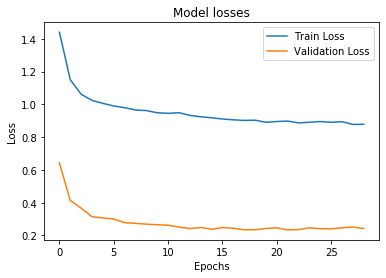

In [39]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title('Model losses')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [35]:
with torch.no_grad():
    inputs = torch.LongTensor(prepare_sequence(test_data[0][0], word_to_ix))
    tag_scores = model(inputs.view(-1,inputs.shape[0]))

    #print(tag_scores)
    # Print the actual words with their tags
    for i,word in enumerate(test_data[0][0]):
        j = int(np.argmax(tag_scores[i]))
        print(f"\t{word}|{ix_to_tag[j]}|{test_data[0][1][i]}")

	Crothnófar|VERB|VERB
	Pól|NOUN|PROPN
	nó|CCONJ|SCONJ
	ba|AUX|AUX
	úrlabhraí|NOUN|NOUN
	maith|ADJ|ADJ
	é|PRON|PRON
	ar|ADP|ADP
	Raidió|NOUN|PROPN
	na|DET|DET
	Gaeltachta|PROPN|PROPN
	agus|CCONJ|CCONJ
	na|DET|DET
	meáin|NOUN|NOUN
	eile|DET|DET
	ag|ADP|ADP
	cosaint|PROPN|NOUN
	na|DET|DET
	n-oifigí|PROPN|NOUN
	poist|PROPN|NOUN
	tuaithe|PRON|NOUN
	,|PUNCT|PUNCT
	gné|PROPN|NOUN
	am-tábhachtach|PROPN|ADJ
	de|ADP|ADP
	shaol|NOUN|NOUN
	sóisialta|NOUN|ADJ
	na|DET|DET
	ndaoine|NOUN|NOUN
	.|PUNCT|PUNCT


In [36]:
pred = []
true = []
for i in range(len(test_data[0][1])):
    pred.append(ix_to_tag[int(np.argmax(tag_scores[i]))])
    true.append(test_data[0][1][i])

compute_accuracy_test(pred,true)

0.6991150442477876

In [40]:
with torch.no_grad():
    # this will be the file to write the outputs
    with open("data/mymodel_output_irish.output", 'w', encoding = "utf-8") as op:
        for instance in test_data:
            # Convert the test sentence into a word ID tensor
            inputs = torch.LongTensor(prepare_sequence(instance[0], word_to_ix))
            # Forward pass
            tag_scores = model(inputs.view(-1,inputs.shape[0]))
            # Find the tag with the highest probability in each position
            outputs = [int(np.argmax(ts)) for ts in tag_scores]
            # Prepare the output to be written in the same format as the test file (word|tag)
            formatted_output = ' '.join([f"{word}|{ix_to_tag[tag_id]}" for word,tag_id in zip(instance[0],outputs)])
            # Write the output
            op.write(formatted_output + '\n')

In [41]:
#Give the path of the OUTPUT file
OUTPUT_FILE = "data/mymodel_output_irish.output"
output = read_data(OUTPUT_FILE)

#Give the path of the ORIGINAL file
REFERENCE_FILE = 'data/irish.test'
gold = read_data(REFERENCE_FILE)

acc = compute_accuracy(output,gold)
print(acc)

====================Reading the file====================
====================Reading the file====================
0.8083885646453656
